## Luxembourg Public Transport Network Analysis

Analysis of GTFS data (2025-11-19 to 2025-12-31) for structural hubs, operational metrics, and disruption impacts.
- Graphs: Transit + walking (<200m) vs. transit-only.
- Tools: NetworkX, GeoPandas, Folium.

### Imports:

In [1]:
###
#: Import necessary libraries

import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from gtfs_kit import read_feed
from sklearn.neighbors import BallTree
from tqdm.auto import tqdm
import warnings
from math import radians, sin, cos, sqrt, atan2  # For haversine
from osgeo import gdal  # For raster data handling

#: Selective warnings (don't suppress everything)
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 150  # Higher res plots

/home/aminghavami/anaconda3/envs/r-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load Datasets
Load stops, stop_times, trips, routes from ZIP.

In [2]:
gtfs_path = "../data/gtfs-20251119-20251231.zip"  # Confirm this file exists
try:
    feed = read_feed(gtfs_path, dist_units='km')
    
    # Explicitly extract and check
    stops = feed.stops
    stop_times = feed.stop_times
    trips = feed.trips
    routes = feed.routes
    
    print("Feed loaded successfully.")
    print(f"Stops: {len(stops) if stops is not None else 0}")
    print(f"Stop_times: {len(stop_times) if stop_times is not None else 0}")
    print(f"Trips: {len(trips) if trips is not None else 0}")
    print(f"Routes: {len(routes) if routes is not None else 0}")
    
    if routes is None:
        print("Error: No routes.txt in GTFS—download a complete feed.")
        # Fallback: Create dummy routes if desperate
        routes = pd.DataFrame({'route_id': stop_times['trip_id'].unique()[:100], 'route_short_name': 'Unknown'})
    
except Exception as e:
    print(f"Load failed: {e}")
    print("Check ZIP integrity—try unzipping manually and inspecting files.")

Feed loaded successfully.
Stops: 2808
Stop_times: 680872
Trips: 29391
Routes: 705


### 3. Preprocess Times
Convert HMS times to seconds since midnight.

In [3]:
def hms_to_seconds(t):
    if pd.isna(t):
        return np.nan
    t = str(t).strip()
    # Handle missing colons (e.g., "090500" -> 9:05:00)
    if ':' not in t and len(t) == 6:
        t = f"{t[:2]}:{t[2:4]}:{t[4:]}"
    elif len(t) == 4:  # HHMM -> HH:MM:00
        t = f"{t[:2]}:{t[2:]}:00"
    # Now parse with timedelta (handles "25:00:00" as next-day, but we mod 86400)
    try:
        td = pd.to_timedelta(t)
        seconds = int(td.total_seconds()) % 86400  # Wrap around midnight
        return seconds
    except:
        print(f"Parse fail: {t}")
        return np.nan

print("Converting arrival_time...")
stop_times["arr_s"] = stop_times["arrival_time"].apply(hms_to_seconds)
print(f"arr_s NaNs: {stop_times['arr_s'].isna().sum()}")

print("Converting departure_time...")
stop_times["dep_s"] = stop_times["departure_time"].apply(hms_to_seconds)
print(f"dep_s NaNs: {stop_times['dep_s'].isna().sum()}")
print("Sample dep_s:", stop_times['dep_s'].dropna().head().tolist())

Converting arrival_time...
arr_s NaNs: 0
Converting departure_time...
dep_s NaNs: 0
Sample dep_s: [53100, 53400, 53760, 53820, 53880]


### 4. Build Graphs
- `G`: Transit edges + walking transfers (<200-400m, ~5 min walk).
- `G_no`: Transit-only.
Uses Haversine for walk distances.

In [20]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c * 1000  # Meters

def build_graph(stops, stop_times, walk_dist_m=400):
    G = nx.DiGraph()
    # Add nodes with positions
    for _, stop in stops.iterrows():
        G.add_node(stop.stop_id, pos=(stop.stop_lon, stop.stop_lat), name=stop.stop_name)

    # Transit edges
    for trip_id, group in tqdm(stop_times.groupby("trip_id"), total=stop_times["trip_id"].nunique()):
        group = group.sort_values("stop_sequence").dropna(subset=["arr_s", "dep_s"])
        prev = None
        for _, row in group.iterrows():
            if prev is not None:
                travel_time = row.arr_s - prev.dep_s
                if travel_time <= 0 or np.isnan(travel_time):
                    travel_time = 60  # Default 1 min
                u, v = prev.stop_id, row.stop_id
                if G.has_edge(u, v):
                    G[u][v]["weight"] = min(G[u][v]["weight"], travel_time)
                else:
                    G.add_edge(u, v, weight=travel_time, type="transit")
            prev = row

    # Walking edges
    coords = np.deg2rad(stops[["stop_lat", "stop_lon"]].values)
    tree = BallTree(coords, metric='haversine')
    max_dist_rad = radians(walk_dist_m / 6371000)  # Approx
    indices = tree.query_radius(coords, r=max_dist_rad)
    for i, neighbors in enumerate(tqdm(indices)):
        u_id = stops.iloc[i].stop_id
        u_lat, u_lon = stops.iloc[i].stop_lat, stops.iloc[i].stop_lon
        for j in neighbors:
            if i == j:
                continue
            v_id = stops.iloc[j].stop_id
            dist_m = haversine(u_lat, u_lon, stops.iloc[j].stop_lat, stops.iloc[j].stop_lon)
            if dist_m < walk_dist_m:
                walk_time = dist_m / 80  # ~5 km/h walking speed, in seconds
                G.add_edge(u_id, v_id, weight=walk_time, type="walk")
                G.add_edge(v_id, u_id, weight=walk_time, type="walk")  # Bidirectional
    return G

# Build graphs (reuse function)
walk_dist = 200  # Meters; from your CLI arg
G = build_graph(stops, stop_times, walk_dist)
G_no = build_graph(stops, stop_times, 0)  # No walking

print(f"G (with walking): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"G_no (transit only): {G_no.number_of_nodes()} nodes, {G_no.number_of_edges()} edges")

100%|██████████| 2808/2808 [00:00<00:00, 2956.87it/s]

G (with walking): 2808 nodes, 8424 edges
G_no (transit only): 2808 nodes, 8424 edges


### 5. Identify Hubs
Top 10 by betweenness centrality (weighted by travel time).

In [ ]:
def get_top_hubs(G, k=20):
    bc = nx.betweenness_centrality(G, weight="weight", normalized=True, k=100)  # Approx for speed
    hubs = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:k]
    df = pd.DataFrame(hubs, columns=["stop_id", "betweenness"])
    df["stop_name"] = df["stop_id"].map({sid: data["name"] for sid, data in G.nodes(data=True)})
    return df

hubs_G = get_top_hubs(G)
hubs_G_no = get_top_hubs(G_no)

print("Top Hubs with Walking:\n", hubs_G.head())
print("\nTop Hubs without Walking:\n", hubs_G_no.head())

Top Hubs with Walking:
         stop_id  betweenness                           stop_name
0  000200405036     0.359593  Luxembourg, Gare Centrale routière
1  000160904001     0.348624               Mersch, Gare routière
2  000160904005     0.271323                  Mersch, Stäereplaz
3  000200412018     0.245733            Gasperich, Schaarfen Eck
4  000200412031     0.232840      Gasperich, Stade de Luxembourg

Top Hubs without Walking:
         stop_id  betweenness                           stop_name
0  000200405036     0.372299  Luxembourg, Gare Centrale routière
1  000160904001     0.364934               Mersch, Gare routière
2  000160904005     0.298607                  Mersch, Stäereplaz
3  000160904009     0.221148             Mersch, Beim Klouschter
4  000160904008     0.221093              Mersch, Mierscherbierg


### 6. Operational Metrics
Trips per stop, headways, route diversity.

In [22]:
# Trips per stop
trips_per_stop = stop_times.groupby("stop_id").size().sort_values(ascending=False)
busiest = pd.DataFrame({"stop_id": trips_per_stop.index, "trips": trips_per_stop.values})
busiest["stop_name"] = busiest["stop_id"].map({sid: data["name"] for sid, data in G.nodes(data=True)})
print("Busiest Stops:\n", busiest.head())


# Debug: Check dep_s column
print("dep_s exists?", 'dep_s' in stop_times.columns)
if 'dep_s' in stop_times.columns:
    print("dep_s shape:", stop_times['dep_s'].shape)
    print("dep_s dtype:", stop_times['dep_s'].dtype)
    print("NaN count in dep_s:", stop_times['dep_s'].isna().sum())
    print("Sample dep_s values:", stop_times['dep_s'].dropna().head().tolist() if not stop_times['dep_s'].isna().all() else "All NaNs!")
    print("Sample departure_time (raw):", stop_times['departure_time'].head().tolist())
else:
    print("dep_s missing—rerun Cell 3!")

# Headways (avg wait time)
stop_departures = stop_times.groupby(["stop_id", pd.cut(stop_times["dep_s"], bins=24*3600//60)])["dep_s"].apply(list)
headways = []
for stop_id, deps_list in tqdm(stop_departures.groupby("stop_id")):
    all_deps = np.concatenate(deps_list.dropna())
    if len(all_deps) > 1:
        diffs = np.diff(np.sort(all_deps))
        diffs = diffs[diffs < 4*3600]  # Filter overnight gaps
        if len(diffs) > 0:
            headways.append({"stop_id": stop_id, "avg_headway_min": np.mean(diffs)/60})

headway_df = pd.DataFrame(headways)
headway_df["stop_name"] = headway_df["stop_id"].map({sid: data["name"] for sid, data in G.nodes(data=True)})
print(f"Median headway: {headway_df['avg_headway_min'].median():.1f} min")

# Route diversity: Unique routes per stop
print("Computing route diversity...")

if 'route_id' not in trips.columns:
    print("Warning: No route_id in trips—skipping diversity.")
    single_line = 0
else:
    # Coerce IDs to str for safe merge
    stop_times['trip_id'] = stop_times['trip_id'].astype(str)
    trips['trip_id'] = trips['trip_id'].astype(str)
    trips['route_id'] = trips['route_id'].astype(str)
    routes['route_id'] = routes['route_id'].astype(str)
    
    # Bridge merge: stop_times -> trips -> routes
    st_trips = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id', how='left')
    merged = st_trips.merge(routes[['route_id', 'route_short_name']], on='route_id', how='left')
    
    # Fill missing route names (rare, but GTFS quirk)
    merged['route_short_name'] = merged['route_short_name'].fillna('Unknown')
    
    routes_per_stop = merged.groupby('stop_id')['route_short_name'].nunique()
    
    single_line = (routes_per_stop == 1).sum() / len(routes_per_stop) * 100
    print(f"Stops with only 1 route: {single_line:.1f}%")
    
    # Optional: Top stops by diversity
    routes_per_stop_df = pd.DataFrame({
        'stop_id': routes_per_stop.index,
        'num_routes': routes_per_stop.values
    })
    routes_per_stop_df['stop_name'] = routes_per_stop_df['stop_id'].map(
        {sid: data["name"] for sid, data in G.nodes(data=True)}
    )
    print("Top stops by route diversity:\n", routes_per_stop_df.nlargest(5, 'num_routes'))

Busiest Stops:
         stop_id  trips                           stop_name
0  000200405020   4433                      Hamilius (Bus)
1  000200405036   4068  Luxembourg, Gare Centrale routière
2  000200405014   3471         Centre, Fondation Pescatore
3  000200417050   3086    Kirchberg, Gare routière Luxexpo
4  000200405013   3030              Centre, F.D. Roosevelt
dep_s exists? True
dep_s shape: (680872,)
dep_s dtype: int64
NaN count in dep_s: 0
Sample dep_s values: [53100, 53400, 53760, 53820, 53880]
Sample departure_time (raw): ['14:45:00', '14:50:00', '14:56:00', '14:57:00', '14:58:00']


100%|██████████| 2808/2808 [00:05<00:00, 502.81it/s]


Median headway: 8.0 min
Computing route diversity...
Stops with only 1 route: 17.6%
Top stops by route diversity:
            stop_id  num_routes                        stop_name
1685  000200419026          50      Limpertsberg, Theater (Bus)
436   000140401004          49          Diekirch, Gare routière
438   000140401006          47        Diekirch, op der Kluuster
2209  000220402034          47  Esch-sur-Alzette, Gare routière
1684  000200419025          46   Limpertsberg, Lycée de Garçons


### 7. Simulate Disruptions
- Node failure: Remove top hub, recompute paths.
- Service cancel: Drop 30% trips.
Join with pop grid for exposure.

In [ ]:
def simulate_disruptions(G, hubs_df, grids, top_n_hubs=5):
    """
    Simulate two types of disruptions:
    1. Node failure: remove one major hub
    2. Service cancellation: randomly remove 30% of trips (edges)
    """
    impacts = []
    
    # Prepare BallTree once (huge speedup)
    stop_coords = np.deg2rad([
        (data['pos'][1], data['pos'][0])  # lat, lon in radians
        for _, data in G.nodes(data=True)
    ])
    tree = BallTree(stop_coords, metric='haversine')
    stop_ids = list(G.nodes())

    print("Starting disruption simulations...")

    # === 1. Node failures (top N hubs) ===
    print(f"Simulating failure of top {top_n_hubs} hubs...")
    for _, hub_row in tqdm(hubs_df.head(top_n_hubs).iterrows(), total=top_n_hubs):
        hub_id = hub_row["stop_id"]
        hub_name = hub_row.get("stop_name", hub_id)

        G_temp = G.copy()
        if hub_id not in G_temp:
            continue
        G_temp.remove_node(hub_id)

        for idx, grid in grids.iterrows():
            if grid['pop'] <= 0:
                continue

            centroid = grid.geometry.centroid
            grid_pt = np.deg2rad([[centroid.y, centroid.x]])  # lat, lon

            # Nearest stop in original graph
            _, idx_nearest = tree.query(grid_pt, k=1)
            source_stop = stop_ids[idx_nearest[0][0]]

            # Baseline travel time to failed hub
            try:
                baseline = nx.shortest_path_length(G, source=source_stop, target=hub_id, weight="weight")
            except nx.NetworkXNoPath:
                baseline = np.inf

            # Best alternative: shortest path to any other top hub still in network
            alternative_times = []
            for _, other_row in hubs_df[hubs_df["stop_id"] != hub_id].head(10).iterrows():  # top 10 alternatives
                oh = other_row["stop_id"]
                if oh not in G_temp:
                    continue
                try:
                    alt_time = nx.shortest_path_length(G_temp, source=source_stop, target=oh, weight="weight")
                    alternative_times.append(alt_time)
                except nx.NetworkXNoPath:
                    continue

            if alternative_times:
                new_time = min(alternative_times)
                delta_sec = max(0, new_time - baseline) if baseline != np.inf else new_time
            else:
                # Total isolation → assume big penalty (e.g. 2 hours extra)
                delta_sec = 7200  # 2 hours in seconds

            impacts.append({
                "grid_id": idx,
                "failed_hub": hub_name,
                "delta_min": delta_sec / 60,
                "pop": grid["pop"],
                "type": "node_failure",
                "scenario": f"Hub {hub_name} down"
            })

    # = 2. Service cancellation (30% of trips removed)
    print("Simulating 30% service cancellation...")
    G_service = G.copy()
    
    # Remove 30% of transit edges randomly (keep walk edges)
    transit_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("type") == "transit"]
    np.random.shuffle(transit_edges)
    edges_to_remove = transit_edges[:int(0.3 * len(transit_edges))]
    
    G_service.remove_edges_from(edges_to_remove)
    print(f"Removed {len(edges_to_remove)} transit edges ({len(edges_to_remove)/len(transit_edges)*100:.1f}%)")

    # Compare travel time from each grid to the #1 hub (or nearest top hub)
    main_hub = hubs_df.iloc[0]["stop_id"]

    for idx, grid in tqdm(grids.iterrows(), total=len(grids)):
        if grid['pop'] <= 0:
            continue

        centroid = grid.geometry.centroid
        grid_pt = np.deg2rad([[centroid.y, centroid.x]])
        _, idx_nearest = tree.query(grid_pt, k=1)
        source_stop = stop_ids[idx_nearest[0][0]]

        try:
            baseline = nx.shortest_path_length(G, source=source_stop, target=main_hub, weight="weight")
        except nx.NetworkXNoPath:
            continue  # was already disconnected

        try:
            degraded = nx.shortest_path_length(G_service, source=source_stop, target=main_hub, weight="weight")
            delta_sec = max(0, degraded - baseline)
        except nx.NetworkXNoPath:
            delta_sec = 7200  # lost access

        impacts.append({
            "grid_id": idx,
            "failed_hub": "30% service cut",
            "delta_min": delta_sec / 60,
            "pop": grid["pop"],
            "type": "service_cancellation",
            "scenario": "30% trips cancelled"
        })

    return pd.DataFrame(impacts)


In [ ]:
###
# = loading population grid 
grid_path = "../data/Pop_grids_1km2.shp"  
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')  # Regenerate .shx from .shp if missing

try:
    grids = gpd.read_file(grid_path)
    print(f"Loaded {len(grids)} grids successfully.")
    print("Columns:", grids.columns.tolist())
    print("CRS:", grids.crs)
    print("Sample pop values:", grids['Pop_grids'].head().tolist() if 'Pop_grids' in grids.columns else "No 'Pop_grids' column?")
except Exception as e:
    print(f"Load failed: {e}")
    # Fallback debug below

grids['Pop_grids'] = pd.to_numeric(grids['Pop_grids'], errors='coerce')  # Ensure numeric
grids = grids.fillna({'Pop_grids': 0})  # Fill NaNs with 0
grids['pop'] = grids['Pop_grids'].astype(int)  # convert Pop_grids (str) to pop (int)


grids = grids[grids['pop'] > 0]  # Filter populated
print(f"After pop filter: {len(grids)} grids")

# = RUN the simulation
print("Loading population grid...")
# Make sure path is correct from your notebook location
grid_path = "../data/Pop_grids_1km2.shp"  # or "data/Pop_grids_1km2.shp"


gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

grids = gpd.read_file(grid_path)

# Fix column name (you said it's 'Pop_grids')
if 'Pop_grids' in grids.columns:
    grids['pop'] = pd.to_numeric(grids['Pop_grids'], errors='coerce').fillna(0).astype(int)
elif 'pop' not in grids.columns:
    print("Warning: No population column found!")
    print("Available columns:", grids.columns.tolist())

grids = grids[grids['pop'] > 0].copy()
print(f"Loaded {len(grids)} populated 1km² grids")

# Run simulation (top 5 hubs + service cancellation)
impact_df = simulate_disruptions(G, hubs_G, grids, top_n_hubs=5)

# Clean up
impact_df = impact_df[impact_df["delta_min"].between(0, 180)]  # clip extreme values
print("\nSimulation complete!")
print(impact_df['type'].value_counts())


Loading population grid...
Loaded 1069 populated 1km² grids
Starting disruption simulations...
Simulating failure of top 5 hubs...


100%|██████████| 5/5 [01:22<00:00, 16.52s/it]


Simulating 30% service cancellation...
Removed 2527 transit edges (30.0%)


100%|██████████| 1069/1069 [00:01<00:00, 694.64it/s]


Simulation complete!
type
node_failure            5345
service_cancellation    1046
Name: count, dtype: int64

Top 10 worst impacted grids:
                            failed_hub  delta_min   pop          type
6   Luxembourg, Gare Centrale routière      120.0   527  node_failure
8   Luxembourg, Gare Centrale routière      120.0  1716  node_failure
9   Luxembourg, Gare Centrale routière      120.0  1332  node_failure
11  Luxembourg, Gare Centrale routière      120.0  2953  node_failure
12  Luxembourg, Gare Centrale routière      120.0   373  node_failure
14  Luxembourg, Gare Centrale routière      120.0   201  node_failure
15  Luxembourg, Gare Centrale routière      120.0    36  node_failure
16  Luxembourg, Gare Centrale routière      120.0  1451  node_failure
17  Luxembourg, Gare Centrale routière      120.0  1666  node_failure
18  Luxembourg, Gare Centrale routière      120.0    37  node_failure


In [61]:
print("\nTop 10 worst impacted grids:")
print(impact_df.nlargest(10, 'delta_min')[['failed_hub', 'delta_min', 'pop', 'type']])


Top 10 worst impacted grids:
                            failed_hub  delta_min   pop          type
6   Luxembourg, Gare Centrale routière      120.0   527  node_failure
8   Luxembourg, Gare Centrale routière      120.0  1716  node_failure
9   Luxembourg, Gare Centrale routière      120.0  1332  node_failure
11  Luxembourg, Gare Centrale routière      120.0  2953  node_failure
12  Luxembourg, Gare Centrale routière      120.0   373  node_failure
14  Luxembourg, Gare Centrale routière      120.0   201  node_failure
15  Luxembourg, Gare Centrale routière      120.0    36  node_failure
16  Luxembourg, Gare Centrale routière      120.0  1451  node_failure
17  Luxembourg, Gare Centrale routière      120.0  1666  node_failure
18  Luxembourg, Gare Centrale routière      120.0    37  node_failure


In [70]:
print("\nTop 10 worst impacted grids:")
print(impact_df[(impact_df['delta_min'] > 0) & (impact_df['delta_min'] <= 120) & (impact_df['type'] == "service_cancellation")].nlargest(10, 'delta_min')[['failed_hub', 'delta_min', 'pop', 'type']])


Top 10 worst impacted grids:
           failed_hub  delta_min   pop                  type
5347  30% service cut      120.0   110  service_cancellation
5348  30% service cut      120.0  1102  service_cancellation
5350  30% service cut      120.0   462  service_cancellation
5354  30% service cut      120.0   923  service_cancellation
5357  30% service cut      120.0   241  service_cancellation
5369  30% service cut      120.0  3129  service_cancellation
5373  30% service cut      120.0  2220  service_cancellation
5376  30% service cut      120.0  3463  service_cancellation
5377  30% service cut      120.0  1083  service_cancellation
5379  30% service cut      120.0   429  service_cancellation


### 8. Visualize Results
Histograms, maps.

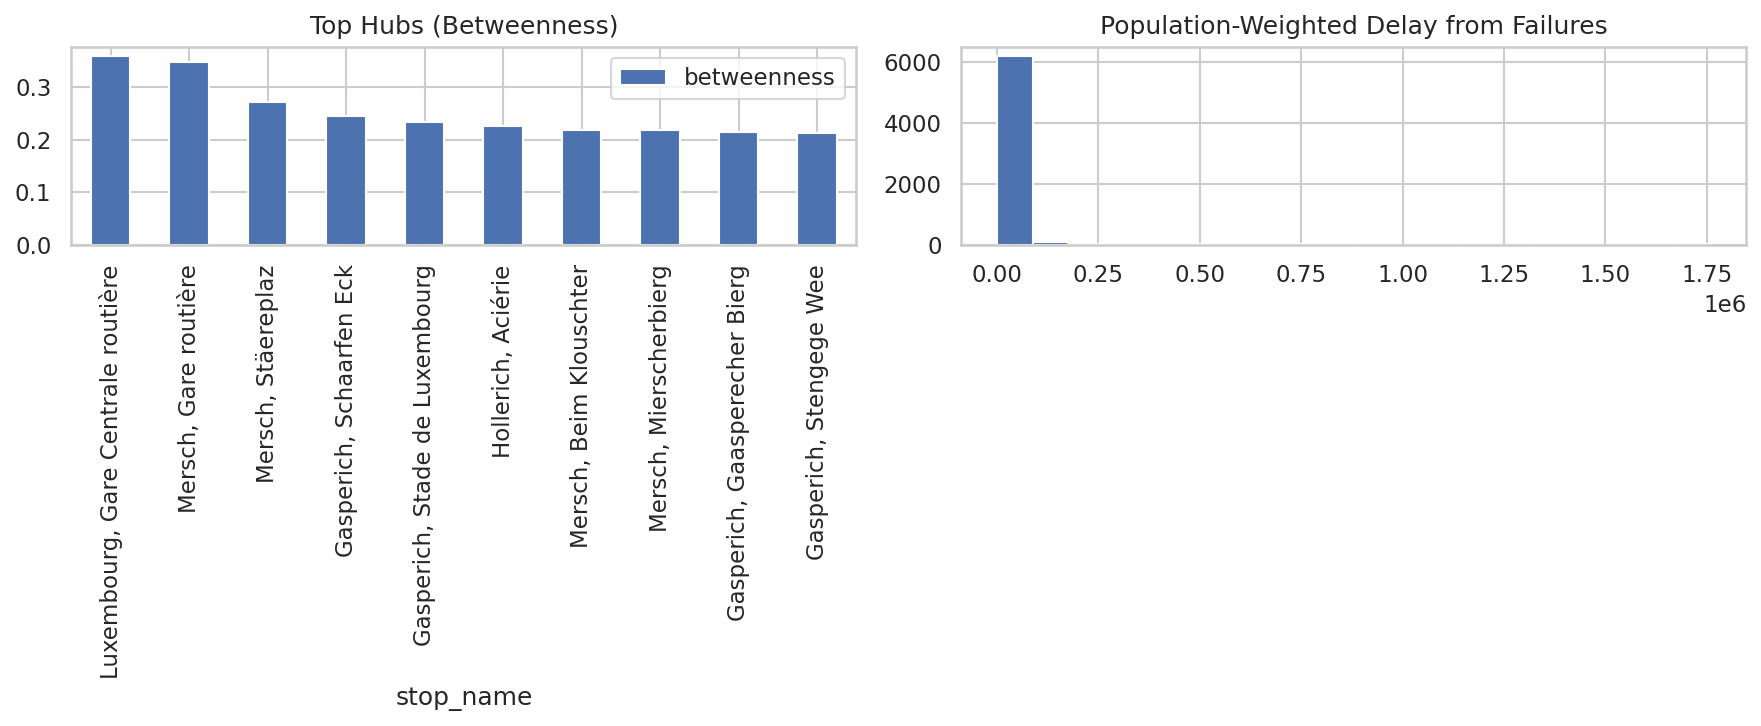

In [66]:
# Bar: Top hubs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
hubs_G.head(10).plot(x="stop_name", y="betweenness", kind="bar", ax=axes[0])
axes[0].set_title("Top Hubs (Betweenness)")

# Histogram: Impacts
impact_df["pop_weighted_delta"] = impact_df["delta_min"] * impact_df["pop"]
impact_df["pop_weighted_delta"].hist(bins=20, ax=axes[1])
axes[1].set_title("Population-Weighted Delay from Failures")

plt.tight_layout()
plt.savefig("hub_impact_summary.png", dpi=300, bbox_inches="tight")
plt.show()

# Interactive map
m = folium.Map(location=[49.6116, 6.1319], zoom_start=10)  # Luxembourg center
for _, stop in stops.head(10).iterrows():  # Example top stops
    folium.CircleMarker(
        location=[stop.stop_lat, stop.stop_lon],
        radius=5,
        popup=stop.stop_name,
        color="red" if stop.stop_id in hubs_G["stop_id"].values else "blue"
    ).add_to(m)
m.save("transit_hubs_map.html")
m  # Display in notebook

### 9. Summary

In [67]:
summary = {
    "Total Stops": len(stops),
    "Median Headway (min)": headway_df["avg_headway_min"].median(),
    "% Single-Route Stops": single_line,
    "Busiest Stop Trips": trips_per_stop.iloc[0],
    "Top Hub": hubs_G.iloc[0]["stop_name"]
}
summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
print(summary_df.to_markdown(index=False))

| Metric               | Value                              |
|:---------------------|:-----------------------------------|
| Total Stops          | 2808                               |
| Median Headway (min) | 8.031218905472636                  |
| % Single-Route Stops | 17.59259259259259                  |
| Busiest Stop Trips   | 4433                               |
| Top Hub              | Luxembourg, Gare Centrale routière |
